In [16]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, load_iris
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest


import matplotlib.pyplot as plt

## Кластеризация

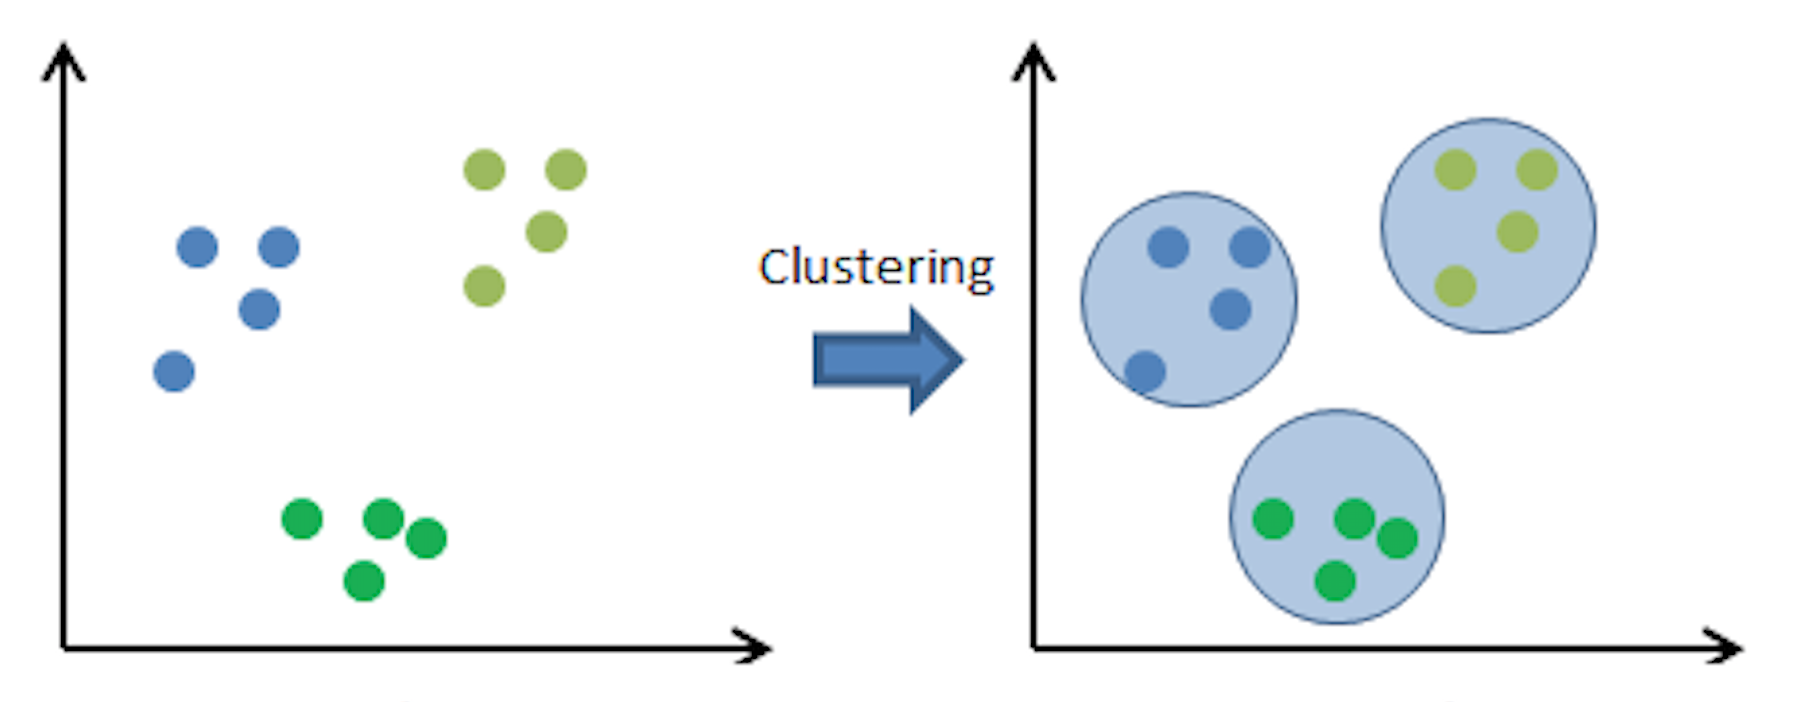

### Зачем?

- Классификация объектов. Попытка понять зависимости между объектами путем выявления их кластерной структуры. 
- Сжатие данных. Можно сократить размер исходной выборки, взяв один или несколько наиболее типичных представителей каждого кластера. 
- Выделение аномалий - объектов, которые не подходят по критериям ни в один кластер. Обнаруженные объекты в дальнейшем обрабатывают отдельно.

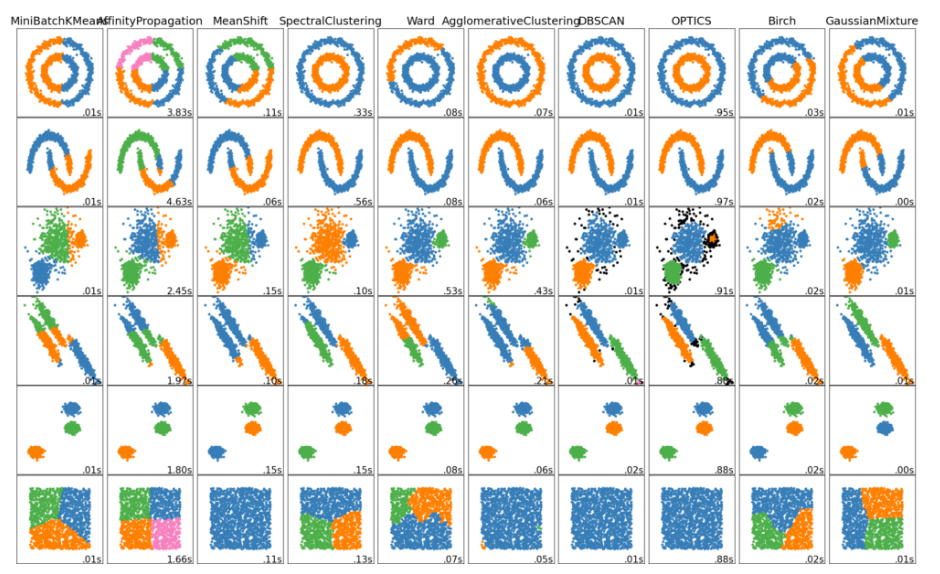

### K-means

#### Основная идея метода 

Итеративное повторение двух шагов:

- Распределение объектов выборки по кластерам
- Пересчёт центров кластеров

Более подробно:

- Выбираются k центров будущих кластеров
- Каждый объект относят к одному из выбранных центров, ориентируясь на расстояние
- Центры кластеров пересчитываются как среднее арифметическое векторов вошедших в этот кластер объектов и обновляются
- Объекты относят к новым центрам кластеров
- ...

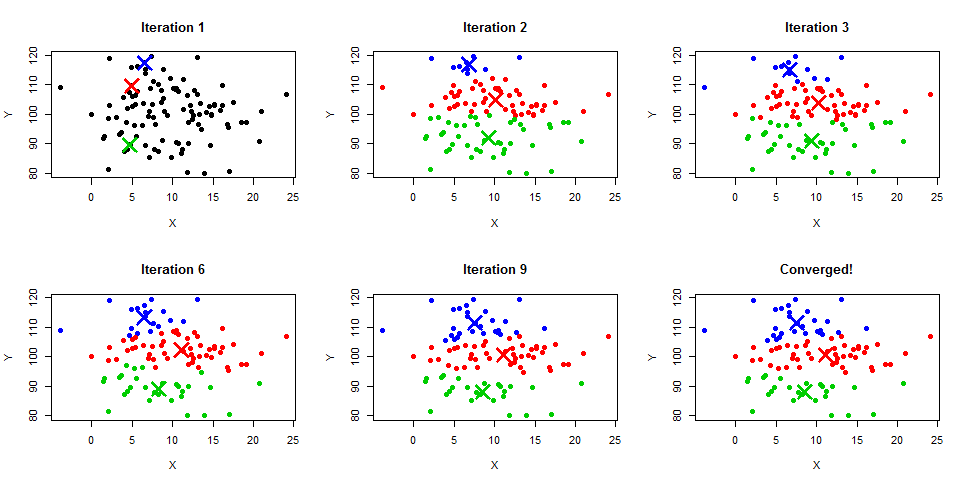

#### Проблемы

- Чувствительность к начальной инициализации
- Заранее необходимо знать k

#### Как подобрать количество кластеров?

Метод локтя

In [17]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, shuffle=True, random_state=2023)

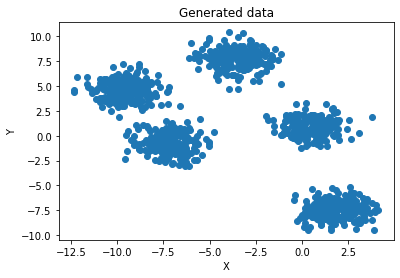

In [18]:
plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

`inertia_` - сумма квадратов расстояний от объектов до ближайших центров кластеров

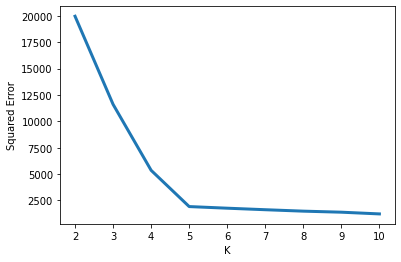

CPU times: user 796 ms, sys: 3.5 ms, total: 799 ms
Wall time: 489 ms


In [19]:
%%time

se = []

for k in range(2, 11):
    clustering = KMeans(n_clusters=k)
    clustering.fit(X)
    se.append(clustering.inertia_)    
 
plt.plot(range(2, 11), se, linewidth='3')
plt.xlabel("K")
plt.ylabel("Squared Error")
plt.show()

Силуэт

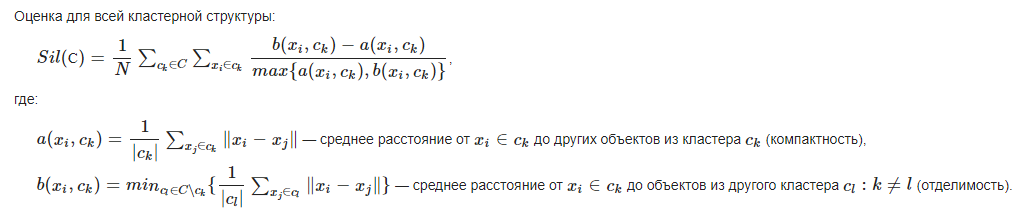

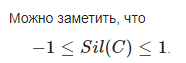

In [20]:
silhouette = []

for k in range(2, 11):
  clustering = KMeans(n_clusters=k).fit(X)
  labels = clustering.labels_
  silhouette.append(silhouette_score(X, labels, metric='euclidean'))

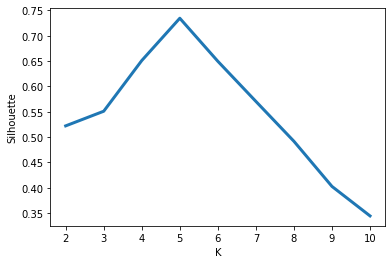

In [21]:
plt.plot(range(2, 11), silhouette, linewidth='3')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

### Метрики качества

#### Индекс Rand


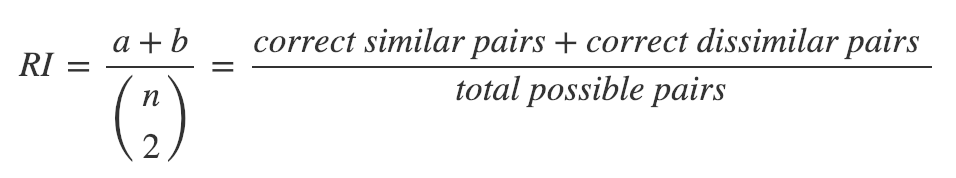

In [22]:
rand_score([0, 0, 1, 2], [0, 0, 1, 1]) # total = 6, TP = 1, TN = 4 => RI = 5/6

0.8333333333333334

#### Индекс Дэвиcа-Боулдина

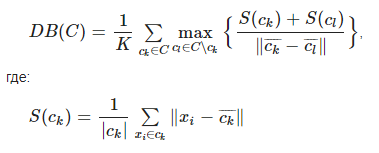

Метрика вычисляет компактность как расстояние от объектов кластера до их центроидов, а отделимость - как расстояние между центроидами.

### Иерархическая кластеризация

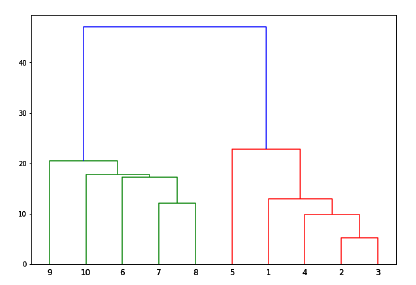

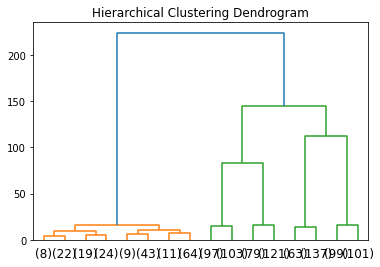

In [23]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.show()

### DBSCAN

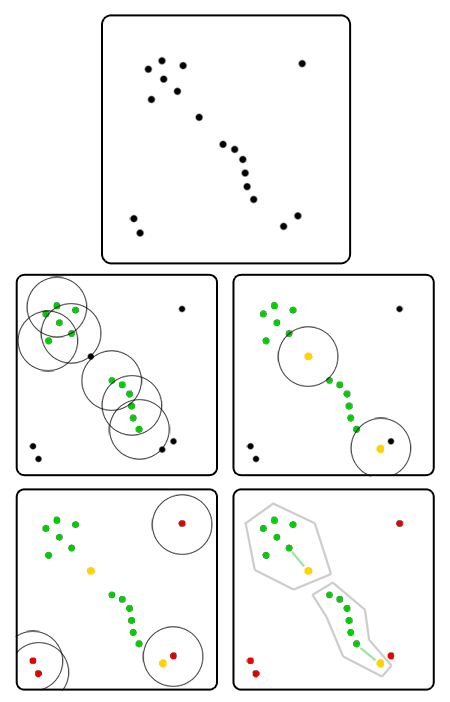

Алгоритм DBSCAN рассматривает кластеры, как участки высокой плотности, разделенные районами с низкой плотностью.

В алгоритме есть два параметра, `min_samples` и `eps`, которые формально определяют, что мы имеем в виду, когда говорим «плотный» . Высокие значения `min_samples` или низкие `eps` указывают на более высокую плотность, необходимую для формирования кластера.

Automatically created module for IPython interactive environment


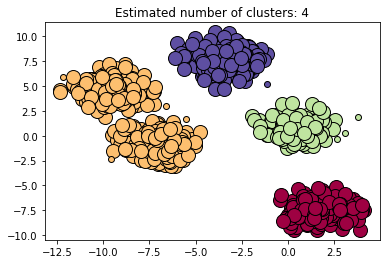

In [24]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(X)


db = DBSCAN(eps=0.3, min_samples=10).fit(scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show();

## Снижение размерности - Метод главных компонент (PCA)

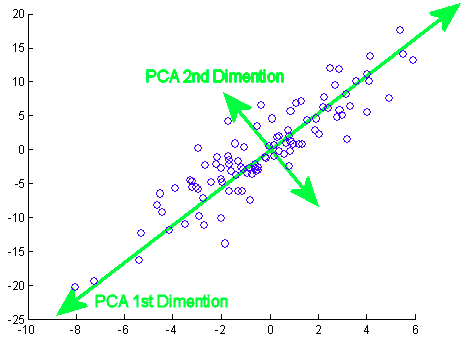

In [25]:
X, y = load_iris(return_X_y=True, as_frame=True)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [26]:
X = StandardScaler().fit_transform(X)

In [27]:
pca = PCA(n_components=2)
res = pca.fit_transform(X)
res = pd.DataFrame(data=res, columns = ['component 1', 'component 2'])
res['target'] = y

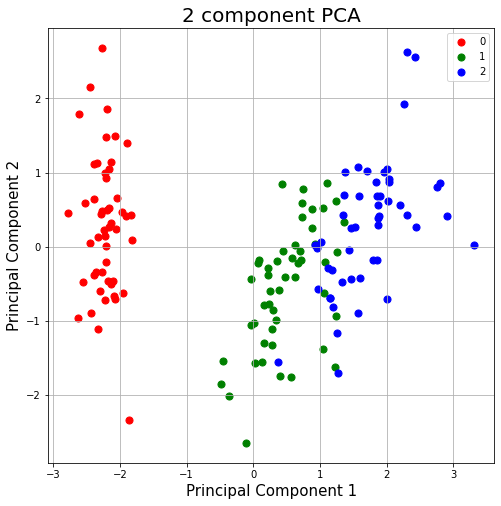

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']

for target, color in zip(res['target'].unique(), colors):
    indicesToKeep = res['target'] == target
    ax.scatter(
        res.loc[indicesToKeep, 'component 1'], 
        res.loc[indicesToKeep, 'component 2'], 
        c=color, 
        s=50
    )
ax.legend(res['target'].unique())
ax.grid()

## Поиск аномалий

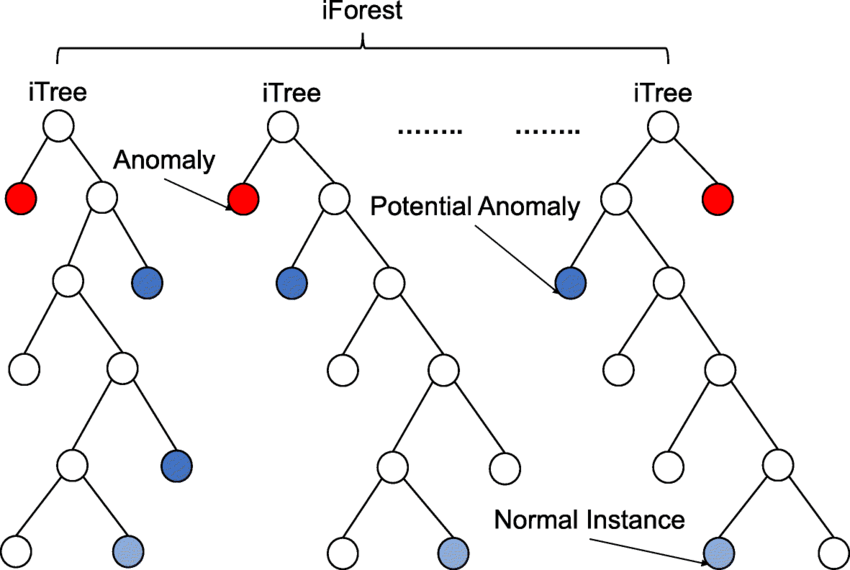

- Каждое дерево строится до исчерпании выборки
- Для построения ветвления в дереве: выбирается случайный признак и случайное расщепление
- Для каждого объекта мера его нормальности – среднее арифметическое глубин листьев, в которые он попал (изолировался)

In [29]:
X = np.random.normal(0, 1, 10)
np.append(X, np.array([100, 200, 10, 5, 2, 1]))
clf = IsolationForest(random_state=2023, n_estimators=5).fit(X.reshape(-1, 1))
clf.predict([[0.1], [-1], [0], [15], [300], [3]])

array([ 1,  1,  1, -1, -1, -1])